# Lab 5: Spam Detection

**Deadline**: Monday, March 15, 5:00 PM

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**TA**: Gautam Dawar <gautam.dawar@mail.utoronto.ca>

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information (.html files are also acceptable).

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://drive.google.com/file/d/1QHl6QdK3c58dGU3fFaXdpMeFfe36MvQq/view?usp=sharing

In [ ]:
%%shell
jupyter nbconvert --to html /content/Lab_4_Data_Imputation.ipynb

In [75]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [2 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [56]:
for line in open('SMSSpamCollection'):
    if line[0] == 'h':
      print(line)
      break
for line in open('SMSSpamCollection'):
    if line[0] == 's':
      print(line)
      break

ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's



- Label value for spam message: 'spam'
- Lael value for non-spam message: 'ham'

### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [57]:
spamCnt = 0
hamCnt = 0

for line in open('SMSSpamCollection'):
  if line[0] == 's':
    spamCnt = spamCnt + 1
  else:
    hamCnt = hamCnt + 1

print("Number of spam messages: ", spamCnt)
print("Number of non-spam messages: ", hamCnt)


Number of spam messages:  747
Number of non-spam messages:  4827


### Part (c) [4 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file. 

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file. 
In our case, the dataset has two fields: 

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [58]:
import torchtext

text_field = torchtext.legacy.data.Field(sequential=True,      # text sequence
                                  tokenize=lambda x: x, # because are building a character-RNN
                                  include_lengths=True, # to track the length of sequences, for batching
                                  batch_first=True,
                                  use_vocab=True)       # to turn each character into an integer index
label_field = torchtext.legacy.data.Field(sequential=False,    # not a sequence
                                   use_vocab=False,     # don't need to track vocabulary
                                   is_target=True,      
                                   batch_first=True,
                                   preprocessing=lambda x: int(x == 'spam')) # convert text to 0 and 1

fields = [('label', label_field), ('sms', text_field)]
dataset = torchtext.legacy.data.TabularDataset("SMSSpamCollection", # name of the file
                                        "tsv",               # fields are separated by a tab
                                        fields)

# dataset[0].sms
# dataset[0].label
train, valid, test = dataset.split([0.6, 0.2, 0.2])

### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

In [59]:
# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

If we have an unbalanced dataset, the model could be just selecting a non-spam message as the output because of the higher probability. This could give a high accuracy of the model, where the model is not actually performing well.

### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [60]:
text_field.build_vocab(train)
#print(text_field.vocab.stoi)
#print(text_field.vocab.itos)

- test_field.vocab.stoi : a dictionary mapping every characters to a numerical identifier.
- test_field.vocab.itos : a list of characters indexed by their numerical identifiers

### Part (g) [2 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

- < unk  >: represents unknown characters.
- < pad >: represents padding which increases the size of messages so that they all have the same length.

### Part (h) [2 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [61]:
train_iter = torchtext.legacy.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [62]:
cnt = 0
maxlen = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
padCnt = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

for batch in train_iter:
  if cnt > 9:
    break
  else:
    maxlen[cnt] = int(batch.sms[1][0])
    for sms in batch.sms[0]:
      for token in sms:
        if token == text_field.vocab.stoi['<pad>']:
          padCnt[cnt] = padCnt[cnt] + 1
  cnt = cnt + 1

print("maximum lengths are: ", maxlen)
print("number of <pad> tokens are: ", padCnt)

maximum lengths are:  [157, 155, 32, 55, 223, 75, 33, 30, 152, 137]
number of <pad> tokens are:  [0, 0, 12, 22, 946, 52, 7, 21, 0, 27]


## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing. 
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a 
fully-connected 
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [48]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [73]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        self.name = 'RNN'
        super(RNN, self).__init__()
        self.emb = torch.eye(input_size)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        x = self.emb[x]
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out

## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [65]:
def get_accuracy(model, data):
    """ Compute the accuracy of the `model` across a dataset `data`
    
    Example usage:
    
    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """
    
    correct, total = 0, 0
    for sms, labels in data:
        output = model(sms[0])
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return correct / total

### Part (b) [4 pt]

Train your model. Plot the training curve of your final model. 
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest. 

In [70]:
def train_rnn_network(model, train, valid, num_epochs=5, learning_rate=1e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc = [], [], []
    epochs = []
    for epoch in range(num_epochs):
        for sms, labels in train:
            optimizer.zero_grad()
            pred = model(sms[0])
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
        losses.append(float(loss))

        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train))
        valid_acc.append(get_accuracy(model, valid))
        print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
              epoch+1, loss, train_acc[-1], valid_acc[-1]))
    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

In [71]:
train_iter = torchtext.legacy.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs
valid_iter = torchtext.legacy.data.BucketIterator(valid,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

Epoch 1; Loss 0.689404; Train Acc 0.504099; Val Acc 0.385650
Epoch 2; Loss 0.687873; Train Acc 0.519491; Val Acc 0.403587
Epoch 3; Loss 0.689592; Train Acc 0.580224; Val Acc 0.464574
Epoch 4; Loss 0.674729; Train Acc 0.630919; Val Acc 0.563229
Epoch 5; Loss 0.685304; Train Acc 0.655178; Val Acc 0.542601
Epoch 6; Loss 0.659655; Train Acc 0.702024; Val Acc 0.600897
Epoch 7; Loss 0.683252; Train Acc 0.736490; Val Acc 0.647534
Epoch 8; Loss 0.674797; Train Acc 0.749038; Val Acc 0.695964
Epoch 9; Loss 0.663270; Train Acc 0.778317; Val Acc 0.830493
Epoch 10; Loss 0.666078; Train Acc 0.793375; Val Acc 0.848430
Epoch 11; Loss 0.620603; Train Acc 0.818638; Val Acc 0.879821
Epoch 12; Loss 0.383500; Train Acc 0.874519; Val Acc 0.840359
Epoch 13; Loss 0.499476; Train Acc 0.887569; Val Acc 0.919283
Epoch 14; Loss 0.226507; Train Acc 0.890748; Val Acc 0.929148
Epoch 15; Loss 0.551131; Train Acc 0.887402; Val Acc 0.845740


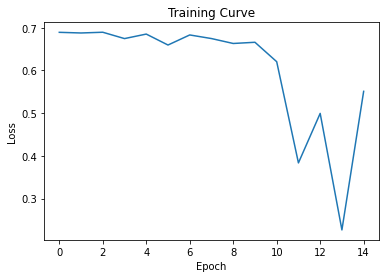

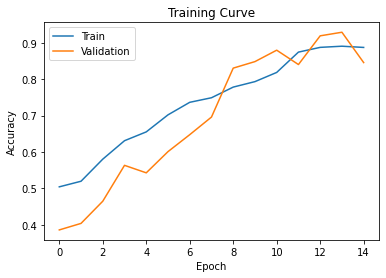

In [77]:
model = RNN(len(text_field.vocab.itos), 100, 2)
train_rnn_network(model, train_iter, valid_iter, 15, 1e-5)

### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch. 
Choose at least 2 hyperparameters that are unrelated to the optimizer.

In [78]:
def train_rnn_network_no_curve(model, train, valid, num_epochs=5, learning_rate=1e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc = [], [], []
    epochs = []
    for epoch in range(num_epochs):
        for sms, labels in train:
            optimizer.zero_grad()
            pred = model(sms[0])
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
        losses.append(float(loss))

        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train))
        valid_acc.append(get_accuracy(model, valid))
        print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
              epoch+1, loss, train_acc[-1], valid_acc[-1]))

In [79]:
#number of hidden units: 150
#num_epochs: 20

first_model = RNN(len(text_field.vocab.itos), 150, 2)
train_rnn_network_no_curve(first_model, train_iter, valid_iter, 20, 1e-5)

Epoch 1; Loss 0.725935; Train Acc 0.469466; Val Acc 0.173991
Epoch 2; Loss 0.685749; Train Acc 0.480843; Val Acc 0.180269
Epoch 3; Loss 0.667322; Train Acc 0.503263; Val Acc 0.184753
Epoch 4; Loss 0.704652; Train Acc 0.534884; Val Acc 0.279821
Epoch 5; Loss 0.686205; Train Acc 0.614690; Val Acc 0.510314
Epoch 6; Loss 0.664570; Train Acc 0.651665; Val Acc 0.577578
Epoch 7; Loss 0.652761; Train Acc 0.677263; Val Acc 0.622422
Epoch 8; Loss 0.693406; Train Acc 0.682282; Val Acc 0.633184
Epoch 9; Loss 0.688069; Train Acc 0.703363; Val Acc 0.663677
Epoch 10; Loss 0.629178; Train Acc 0.720930; Val Acc 0.675336
Epoch 11; Loss 0.326625; Train Acc 0.733311; Val Acc 0.907623
Epoch 12; Loss 0.468660; Train Acc 0.892254; Val Acc 0.933632
Epoch 13; Loss 0.497332; Train Acc 0.888238; Val Acc 0.939013
Epoch 14; Loss 0.353830; Train Acc 0.919859; Val Acc 0.905830
Epoch 15; Loss 0.514963; Train Acc 0.929229; Val Acc 0.921076
Epoch 16; Loss 0.186039; Train Acc 0.918688; Val Acc 0.906726
Epoch 17; Loss 0.

In [81]:
#increased number of hidden units: 200
#num_epochs: 20
#increased lr: 5e-5

second_model = RNN(len(text_field.vocab.itos), 200, 2)
train_rnn_network_no_curve(second_model, train_iter, valid_iter, 20, 5e-5)

Epoch 1; Loss 0.679200; Train Acc 0.674084; Val Acc 0.677130
Epoch 2; Loss 0.751597; Train Acc 0.634265; Val Acc 0.397309
Epoch 3; Loss 0.292762; Train Acc 0.878032; Val Acc 0.939910
Epoch 4; Loss 0.187674; Train Acc 0.923708; Val Acc 0.945291
Epoch 5; Loss 0.161972; Train Acc 0.932742; Val Acc 0.944395
Epoch 6; Loss 0.048458; Train Acc 0.940773; Val Acc 0.945291
Epoch 7; Loss 0.147203; Train Acc 0.935419; Val Acc 0.924664
Epoch 8; Loss 0.035130; Train Acc 0.947967; Val Acc 0.941704
Epoch 9; Loss 0.105307; Train Acc 0.947633; Val Acc 0.945291
Epoch 10; Loss 0.062518; Train Acc 0.956500; Val Acc 0.953363
Epoch 11; Loss 0.016612; Train Acc 0.943785; Val Acc 0.938117
Epoch 12; Loss 0.040773; Train Acc 0.951146; Val Acc 0.965919
Epoch 13; Loss 0.021133; Train Acc 0.942613; Val Acc 0.911211
Epoch 14; Loss 0.076483; Train Acc 0.960181; Val Acc 0.947085
Epoch 15; Loss 0.046494; Train Acc 0.955329; Val Acc 0.935426
Epoch 16; Loss 0.057177; Train Acc 0.962690; Val Acc 0.955157
Epoch 17; Loss 0.

In [90]:
class myRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        self.name = 'myRNN'
        super(myRNN, self).__init__()
        self.emb = torch.eye(input_size)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        x = self.emb[x]
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)
        # Pass the output of the last time step to the classifier
        out = self.fc(torch.max(out, dim=1)[0])
        return out

In [92]:
#new RNN
#number of hidden units: 200
#decreased num_epochs: 15
#lr: 5e-5

third_model = myRNN(len(text_field.vocab.itos), 200, 2)
train_rnn_network_no_curve(third_model, train_iter, valid_iter, 15, 5e-5)

Epoch 1; Loss 0.693817; Train Acc 0.664380; Val Acc 0.383857
Epoch 2; Loss 0.325968; Train Acc 0.705705; Val Acc 0.494170
Epoch 3; Loss 0.216397; Train Acc 0.935586; Val Acc 0.912108
Epoch 4; Loss 0.411475; Train Acc 0.937594; Val Acc 0.913901
Epoch 5; Loss 0.198719; Train Acc 0.941442; Val Acc 0.921076
Epoch 6; Loss 0.164111; Train Acc 0.913836; Val Acc 0.966816
Epoch 7; Loss 0.170448; Train Acc 0.948804; Val Acc 0.957848
Epoch 8; Loss 0.071259; Train Acc 0.952986; Val Acc 0.958744
Epoch 9; Loss 0.075922; Train Acc 0.942781; Val Acc 0.964126
Epoch 10; Loss 0.132428; Train Acc 0.955998; Val Acc 0.950673
Epoch 11; Loss 0.238174; Train Acc 0.953990; Val Acc 0.945291
Epoch 12; Loss 0.056733; Train Acc 0.951146; Val Acc 0.965919
Epoch 13; Loss 0.063412; Train Acc 0.954994; Val Acc 0.958744
Epoch 14; Loss 0.071442; Train Acc 0.958173; Val Acc 0.945291
Epoch 15; Loss 0.065657; Train Acc 0.961519; Val Acc 0.954260


In [95]:
#new RNN
#number of hidden units: 200
#decreased num_epochs: 10
#increased lr: 5e-4

fourth_model = myRNN(len(text_field.vocab.itos), 200, 2)
train_rnn_network_no_curve(fourth_model, train_iter, valid_iter, 10, 5e-4)

Epoch 1; Loss 0.247921; Train Acc 0.945290; Val Acc 0.971300
Epoch 2; Loss 0.072456; Train Acc 0.960515; Val Acc 0.966816
Epoch 3; Loss 0.340389; Train Acc 0.969383; Val Acc 0.973094
Epoch 4; Loss 0.127796; Train Acc 0.977246; Val Acc 0.973094
Epoch 5; Loss 0.205022; Train Acc 0.979756; Val Acc 0.972197
Epoch 6; Loss 0.042923; Train Acc 0.981596; Val Acc 0.975785
Epoch 7; Loss 0.023787; Train Acc 0.988456; Val Acc 0.974888
Epoch 8; Loss 0.012587; Train Acc 0.988623; Val Acc 0.982063
Epoch 9; Loss 0.012695; Train Acc 0.990798; Val Acc 0.981166
Epoch 10; Loss 0.009592; Train Acc 0.994813; Val Acc 0.982960


The best model with highest training and validation accuracy was the fourth_model recording an accuracy of 0.995(train) and 0.983(val).

### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [97]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.legacy.data.Dataset(
    [e for e in valid.examples if e.label == 1],
    valid.fields)
valid_spam_loader = torchtext.legacy.data.BucketIterator(valid_spam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

# Create a Dataset of only non-spam validation examples
valid_nospam = torchtext.legacy.data.Dataset(
    [e for e in valid.examples if e.label == 0],
    valid.fields)
valid_nospam_loader = torchtext.legacy.data.BucketIterator(valid_nospam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

false_pos_rate = 1 - get_accuracy(fourth_model, valid_nospam_loader)
false_neg_rate = 1 - get_accuracy(fourth_model, valid_spam_loader)

print("false positive rate: ", false_pos_rate)
print("false negative rate: ", false_neg_rate)

false positive rate:  0.008298755186721962
false negative rate:  0.08609271523178808


### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

- false positive: This would imply where a non-spam message is recieved, however classified as a spam. The impact of this would be significant since the message classified as spam could actually be an important message.

- false negative: This would imply where a spam message is recieved, however classified as a non-spam. The impact of this would not be significant as false positive, since the reciever would just be getting an annoying message.

## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [98]:
test_iter = torchtext.legacy.data.BucketIterator(test,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [99]:
final_acc = get_accuracy(fourth_model, test_iter)

In [100]:
print("Final test accuracy: ", final_acc)

Final test accuracy:  0.9793536804308797


### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [101]:
# Create a Dataset of only spam validation examples
test_spam = torchtext.legacy.data.Dataset(
    [e for e in test.examples if e.label == 1],
    valid.fields)
test_spam_loader = torchtext.legacy.data.BucketIterator(test_spam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

# Create a Dataset of only non-spam validation examples
test_nospam = torchtext.legacy.data.Dataset(
    [e for e in test.examples if e.label == 0],
    valid.fields)
test_nospam_loader = torchtext.legacy.data.BucketIterator(test_nospam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

false_pos_rate = 1 - get_accuracy(fourth_model, test_nospam_loader)
false_neg_rate = 1 - get_accuracy(fourth_model, test_spam_loader)

print("false positive rate: ", false_pos_rate)
print("false negative rate: ", false_neg_rate)

false positive rate:  0.011494252873563204
false negative rate:  0.06369426751592355


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [104]:
msg = "machine learning is sooo cool!"
msg_arry = []

for char in msg:
  msg_arry.append(torch.tensor(text_field.vocab.stoi[char]))

out = torch.stack(msg_arry)
out.unsqueeze_(0)

prob = F.softmax(fourth_model(out), dim=1)[0][1].item()

print("My model's prediction of the probability that the SMS message is spam: ", prob)

My model's prediction of the probability that the SMS message is spam:  0.019493114203214645


### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

I think detecting spam is an easy task compared to other machine learning tasks such as generating a caption for random photos.

A Naive Bayes Classifiers could be used as a baseline model, where P(class|data) = (P(data|class)*P(class))/P(data). Based on the number of occurances of each word in a ham/spam message, we could classify the message as more likely to be ham/spam message by comparing it to the number of occurances of a specific word in the whole ham/spam message dataset. For example, if we are looking at the word "please" in the message, we see if the word occurs more in spam or ham message in the dataset. Then, if it is likely to appear in spam message, we add that probability computed by the equation P(class|data) = (P(data|class)*P(class))/P(data) to probability_spam, and vice versa. Finally, we compare the probability_spam to probability_ham and choose the greater one.